In [1]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Dense
from keras.metrics import *
from keras.models import Sequential
import tensorflow_addons as tfa
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

/tmp/ipykernel_10337/2935666189.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-07 14:08:44.215246: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 14:08:44.253210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 14:08:44.253253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin

In [2]:
model_metrics =[BinaryAccuracy(name = 'accuracy'),
         TruePositives(thresholds = 0.5, name = 'tp'),
         TrueNegatives(thresholds = 0.5, name = 'tn'),
         FalsePositives(thresholds = 0.5, name = 'fp'),
         FalseNegatives(thresholds = 0.5, name = 'fn'),
         PrecisionAtRecall(recall = 0.5, name = 'precision'),
         SensitivityAtSpecificity(0.5, name = 'sensitivity'),
         SpecificityAtSensitivity(sensitivity = 0.5,
                                  name = 'specificity'),
         Recall(name='recall')]

In [3]:
data_sheet = pd.read_csv('../data/feelings.csv')
data_sheet['rating'] = pd.to_numeric(data_sheet['rating'], errors = 'coerce')
data_sheet['sentiment'] = pd.to_numeric(data_sheet['sentiment'], errors = 'coerce')

X = data_sheet.drop(['sentiment'], axis = 1)

data_sheet['sentiment'] = data_sheet['sentiment'].apply(lambda x: 1 if x == 1 else 0)
Y = data_sheet['sentiment']

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

In [5]:
data_scaler = StandardScaler()

X_train = data_scaler.fit_transform(X_train)
X_test = data_scaler.fit_transform(X_test)

X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)



In [6]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') # Because it's a binary classification model
])

In [7]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=model_metrics)

In [8]:
learning_rate = ReduceLROnPlateau(monitor = 'accuracy',
                                 factor = 0.2,
                                 patience = 1,
                                 min_lr = 0.000001,
                                 verbose = 1)

In [9]:
%%time

    hist = model.fit(X_train,
                 Y_train,
                 epochs = 100,
                 validation_data = (X_test, Y_test),
                 validation_steps = 10,
                 callbacks = [learning_rate],
                 verbose = 1)

Epoch 1/100
13/13 [==============================] - 1s 30ms/step - loss: 0.6646 - accuracy: 0.7208 - tp: 158.0000 - tn: 126.0000 - fp: 71.0000 - fn: 39.0000 - precision: 0.8623 - sensitivity: 0.8426 - specificity: 0.9036 - recall: 0.8020 - val_loss: 0.5911 - val_accuracy: 1.0000 - val_tp: 49.0000 - val_tn: 50.0000 - val_fp: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5490 - accuracy: 0.9975 - tp: 197.0000 - tn: 196.0000 - fp: 1.0000 - fn: 0.0000e+00 - precision: 1.0000 - sensitivity: 1.0000 - specificity: 1.0000 - recall: 1.0000 - val_loss: 0.4957 - val_accuracy: 1.0000 - val_tp: 49.0000 - val_tn: 50.0000 - val_fp: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/100
 1/13 [=>............................] - ETA: 0s 

In [10]:
acc = hist.history['accuracy']
loss = hist.history['loss']
fp = hist.history['fp']
fpv = hist.history['val_fp']
fn = hist.history['fn']
fnv = hist.history['val_fn']
tp = hist.history['tp']
tpv = hist.history['val_tp']
tn = hist.history['tn']
tnv= hist.history['val_tn']
FP = hist.history['fp'][-1]
FN = hist.history['fn'][-1]
TP = hist.history['tp'][-1]
TN = hist.history['tn'][-1]
LOSS = hist.history['loss'][-1]
LOSSV = hist.history['val_loss'][-1]
ACC = hist.history['accuracy'][-1]
ACCV = hist.history['val_accuracy'][-1]
PRE = hist.history['precision'][-1]
PREV = hist.history['val_precision'][-1]
REC = hist.history["recall"][-1]
RECV = hist.history["val_recall"][-1]
LR = hist.history['lr'][-1]

In [11]:
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

OACC = (TP+TN)/(TP+FP+FN+TN)
ACCCM = (TP+TN)/(TN + TP + FP + FN)
FM = (2 * PRE * REC)/(PRE + REC)
F1S = 2*((PRE*REC))/(PRE+REC)
F1S2 = 2 * TP/(2 * TP + FP + FN)

In [12]:
print(f'True positives" {tp}')
print(f'False negativas" {fp}')
print(f'True negatives" {tn}')
print(f'False negatives" {fn}')

print('-------------------------------------')
print("Confusion matrix")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")
print('-------------------------------------')
print(f'Confusion matrix accuracy: {round(ACCCM, 2)*100-2}%')



True positives" [158.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197.0]
False negativas" [71.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

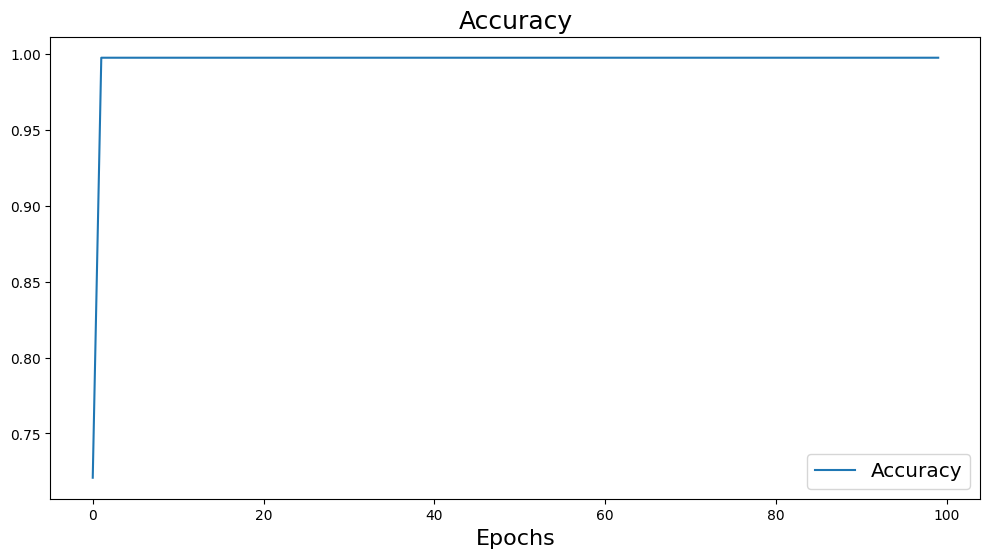

In [13]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['accuracy'])
plt.legend(['Accuracy',],
          loc = 'lower right', fontsize = 'x-large')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel("", fontsize = 18)
plt.title('Accuracy', fontsize = 18)
plt.show()



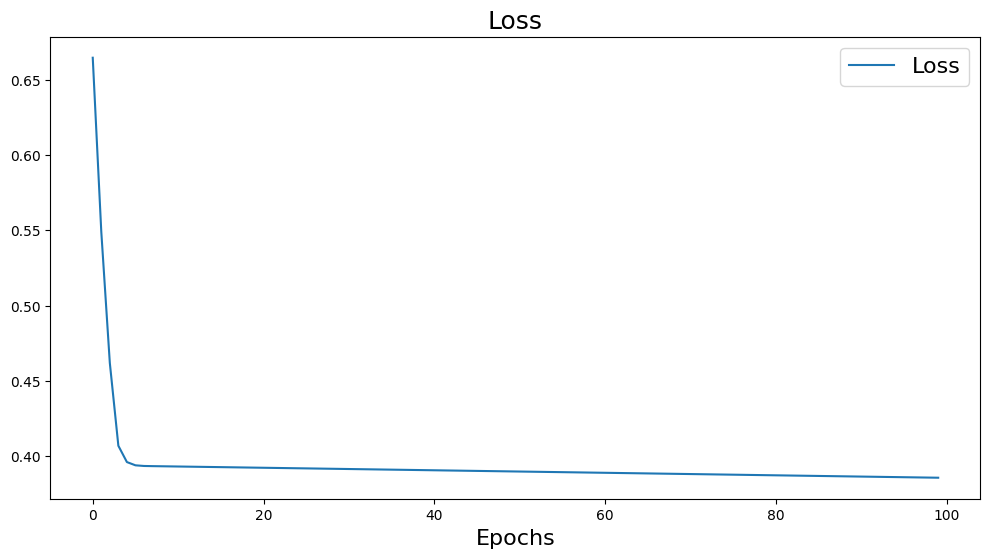

In [14]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['loss'])
plt.legend(['Loss',],
          loc = 'upper right', fontsize = 16)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('', fontsize = 16)
plt.title('Loss', fontsize = 18)
plt.show()

In [21]:
tf.keras.backend.clear_session()

In [28]:
studentNumber6 = data_sheet.iloc[24, 1:2]
studentNumber6 = data_scaler.transform(studentNumber6.values.reshape(1, -1))
prediction = model.predict(studentNumber6)

if prediction >= 0.5:
    print("Sentimento positivo")
else:
    print("Sentimento negativo")

print(prediction)

client_x = np.array([4.6])
client_x = data_scaler.transform(client_x.reshape(1, -1))
pred = model.predict(client_x)

print(pred)

if pred >= 0.5:
    print("Positive feeling")
else:
    print("Negative feeling")

1/1 [==============================] - 0s 18ms/step
Sentimento negativo
[[0.2381893]]
1/1 [==============================] - 0s 19ms/step
[[0.6915827]]
Positive feeling


/home/marco/.config/conda_envs/feelings/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/marco/.config/conda_envs/feelings/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [29]:
model.save('rating_model.h5')

/home/marco/.config/conda_envs/feelings/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
